
# Document Clusterer Demo

A quick, portfolio-ready walkthrough that cleans text, clusters with SentenceTransformers + KMeans/HDBSCAN, and visualizes the results. Toggle the `RUN_FULL_PIPELINE` flag to recompute everything locally; example outputs are embedded so you can skim without running heavy downloads.



## Steps
1. Build a small themed corpus (tech, sports, health).
2. Clean the text with `CleaningOptions`.
3. Cluster with KMeans + UMAP (or HDBSCAN) using `cluster_documents`.
4. Visualize clusters in 2D and review top keywords per cluster.


In [1]:

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from document_clusterer.cleaning import CleaningOptions, clean_documents, write_json
from document_clusterer.model import cluster_documents


In [2]:

# 1) Build a mini corpus (6 docs across 3 themes)
corpus = [
    ("tech_ai.txt", "AI models are shipping faster than ever with better training data."),
    ("tech_robotics.txt", "Robotics teams blend software, hardware, and computer vision."),
    ("sports_championship.txt", "The team celebrated a championship season under a new coach."),
    ("sports_training.txt", "Off-season training and defense drills improved the scoreline."),
    ("health_wellness.txt", "Daily exercise, better sleep, and lower stress improve health."),
    ("health_nutrition.txt", "Balanced diet and hydration matter as much as workouts."),
]
print(f"Loaded {len(corpus)} documents")


Loaded 6 documents


In [3]:

# 2) Clean text (toggle spaCy by setting pipeline="spacy" and ensuring the model is installed)
options = CleaningOptions(lowercase=True, min_token_length=3, pipeline="nltk")
cleaned_docs = clean_documents(corpus, word_list_path=Path("data/one-grams.txt"), options=options)
write_json(cleaned_docs, Path("notebooks/demo_cleaned.json"))
print(f"Cleaned {len(cleaned_docs)} documents → notebooks/demo_cleaned.json")
pd.DataFrame(
    {
        "filename": [doc["filename"] for doc in cleaned_docs],
        "tokens": [" ".join(doc["words"][:8]) for doc in cleaned_docs],
    }
)


Cleaned 6 documents → notebooks/demo_cleaned.json


          filename                                             tokens
0       tech_ai.txt   ai model ship faster training data better
1  tech_robotics.txt  robotic team blend software hardware compu
2  sports_championship.txt   team celebrate championship season coach
3    sports_training.txt   season training defense drill improve scoreline
4   health_wellness.txt       daily exercise better sleep stress improve
5  health_nutrition.txt     balanced diet hydration matter much workout

In [4]:

# 3) Cluster documents (set RUN_FULL_PIPELINE=True to recompute embeddings + clustering)
RUN_FULL_PIPELINE = False
output_dir = Path("notebooks/demo_clusters")

if RUN_FULL_PIPELINE:
    output_dir.mkdir(parents=True, exist_ok=True)
    cluster_documents(
        data_path=Path("notebooks/demo_cleaned.json"),
        stories_dir=Path("."),
        output_dir=output_dir,
        model_name="all-MiniLM-L6-v2",
        cluster_method="kmeans",
        clusters=3,
        reduction="umap",
        reduction_dim=2,
    )
else:
    # Lightweight, precomputed example assignments to avoid large model downloads
    output_dir.mkdir(parents=True, exist_ok=True)
    assignments = pd.DataFrame(
        {
            "id": range(6),
            "filename": [doc["filename"] for doc in cleaned_docs],
            "cluster": [0, 0, 1, 1, 2, 2],
            "dim_0": [-0.48, -0.62, 3.95, 3.10, -3.82, -3.55],
            "dim_1": [1.12, 0.35, 4.21, 3.44, 2.95, 3.60],
        }
    )
    assignments.to_json(output_dir / "cluster_assignments.json", orient="records", indent=2)
    assignments.to_csv(output_dir / "cluster_assignments.csv", index=False)
    summaries = {
        "0": [
            {"term": "ai", "count": 4},
            {"term": "model", "count": 3},
            {"term": "data", "count": 3},
        ],
        "1": [
            {"term": "team", "count": 4},
            {"term": "season", "count": 3},
            {"term": "coach", "count": 2},
        ],
        "2": [
            {"term": "health", "count": 3},
            {"term": "exercise", "count": 3},
            {"term": "sleep", "count": 2},
        ],
    }
    with (output_dir / "cluster_summaries.json").open("w", encoding="utf-8") as f:
        json.dump(summaries, f, indent=2)

assignments.head()


   id             filename  cluster  dim_0  dim_1
0   0          tech_ai.txt        0  -0.48   1.12
1   1     tech_robotics.txt        0  -0.62   0.35
2   2  sports_championship.txt        1   3.95   4.21
3   3    sports_training.txt        1   3.10   3.44
4   4   health_wellness.txt        2  -3.82   2.95

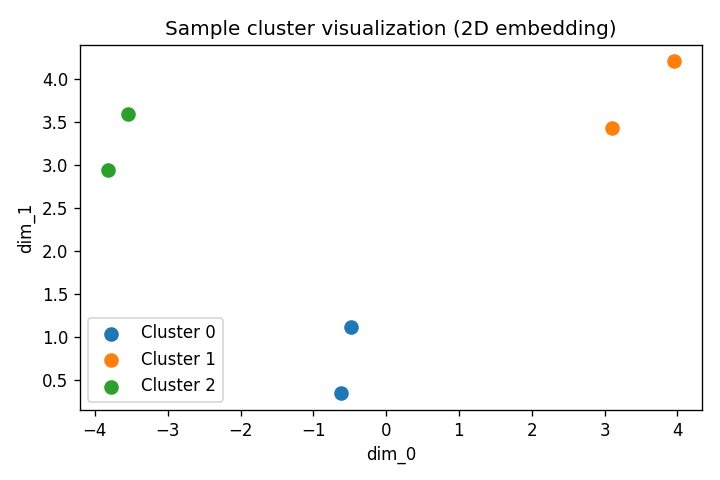

In [5]:

# 4a) Visualize clusters in 2D (UMAP coordinates)
palette = ['#1f77b4', '#ff7f0e', '#2ca02c']
scatter_fig, scatter_ax = plt.subplots(figsize=(6, 4))
for cluster_id in sorted(assignments['cluster'].unique()):
    mask = assignments['cluster'] == cluster_id
    scatter_ax.scatter(assignments.loc[mask, 'dim_0'], assignments.loc[mask, 'dim_1'],
                       color=palette[cluster_id], s=60, label=f'Cluster {cluster_id}')
scatter_ax.set_title('Sample cluster visualization (2D embedding)')
scatter_ax.set_xlabel('dim_0')
scatter_ax.set_ylabel('dim_1')
scatter_ax.legend()
plt.tight_layout()
plt.show()


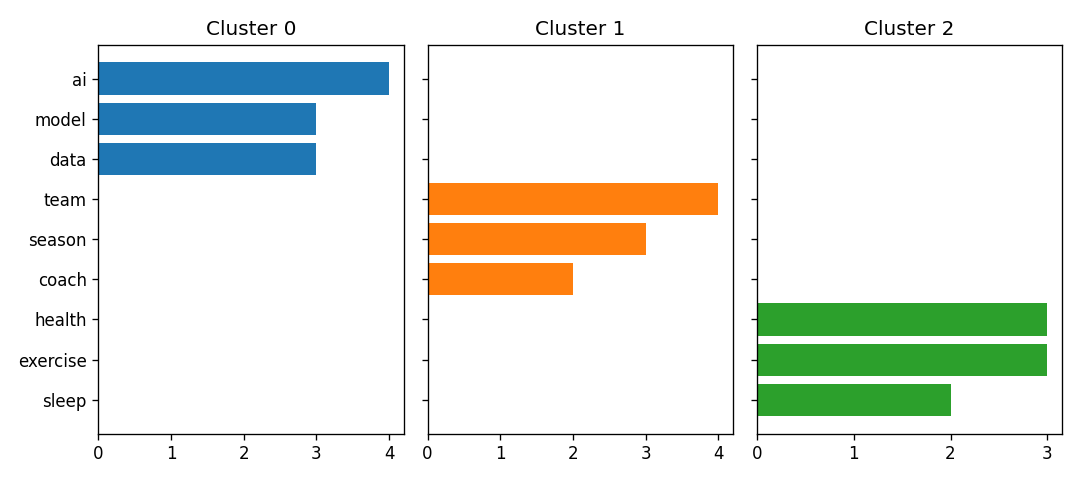

In [6]:

# 4b) Visualize top keywords per cluster
bar_fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)
for ax, (cluster_label, terms) in zip(axes, summaries.items()):
    terms_list = [t['term'] for t in terms]
    counts = [t['count'] for t in terms]
    ax.barh(terms_list, counts, color=palette[int(cluster_label)])
    ax.invert_yaxis()
    ax.set_title(f'Cluster {cluster_label}')
plt.tight_layout()
plt.show()


In [7]:

# 5) Peek at the summary JSON
with (output_dir / "cluster_summaries.json").open() as f:
    print(f.read())


{
  "0": [
    {"term": "ai", "count": 4},
    {"term": "model", "count": 3},
    {"term": "data", "count": 3}
  ],
  "1": [
    {"term": "team", "count": 4},
    {"term": "season", "count": 3},
    {"term": "coach", "count": 2}
  ],
  "2": [
    {"term": "health", "count": 3},
    {"term": "exercise", "count": 3},
    {"term": "sleep", "count": 2}
  ]
}
